In [0]:
!pip install pysoundfile

In [0]:
# Importing Required Libraries
import numpy as np
import scipy.optimize as spopt
import scipy.fftpack as spfft
import cvxpy as cvx
import soundfile as sf
import math
import random
from IPython.display import Audio
from sklearn.linear_model import OrthogonalMatchingPursuit
from scipy.linalg import qr
import matplotlib.pyplot as plt

In [0]:
# Reading data file into COLAB environment
from google.colab import files

uploaded = files.upload()


Saving sum_sig.wav to sum_sig (1).wav
Saving t1.wav to t1 (1).wav
Saving t2.wav to t2 (1).wav
Saving test9.wav to test9 (1).wav


In [0]:
t1, rate = sf.read('t1.wav')
t2, rate = sf.read('t2.wav')

n = len(t1)
m = int(n*(3/10))

t1f = spfft.dct(t1, norm='ortho')
t2f = spfft.dct(t2, norm='ortho')


ind1=np.flip(np.argsort(t1f),-1)

ind1 = ind1[:m]

ind2=np.flip(np.argsort(t2f),-1)

ind2 = ind2[:m]

sensing_matrix_1 = np.zeros((m,n))
sensing_matrix_2 = np.zeros((m,n))

for i in range(m):
    sensing_matrix_1[i,ind1[i]] = 1

for i in range(m):
    sensing_matrix_2[i,ind2[i]] = 1

In [0]:
# Calculating the fitness value for the population
def fitness(pop,rate,o_sig,f_sig,A):  # 'pop' is the population, 'rate' is the sampling frequency of the signal, 'o_sig' & 'f_sig' is the original time domain signal and its dct respectively. 'A' is the idct of the identity matrix of size n by n.
    pp,mm,nn = np.shape(pop)          # 'pp' population size. 'mm' rows. 'nn' columns of the sensing matrix.
    fit_level = np.zeros(pp)          # Initializing the fitness array
    # Doing reconstruction and calculating rmse for each sensing matrix in the population
    for i in range(pp):
        cm = pop[i,:,:]               # Picking a sensing matrix from the population
        sig_samp = np.dot(cm,o_sig)   # Taking 'm' samples from the input signal. Our hope is that these are the ones which carry most of the information. And its more than just a hope kamran.
        A1 = np.dot(cm,A)             # Obtaining the matrix 'phi*si'
        r_sigf = np.dot(np.transpose(A1), sig_samp) # Reconstructing the signal in dct domain using the fact that the transpose of the matrix is its inverse. Exploiting its orthogonality property.
        r_sigt = spfft.idct(r_sigf, norm='ortho', axis=0) # Taking idct of the reconstructed signal to get the time domain signal
        noise = r_sigt - o_sig
        rp_sig = np.sum(r_sigt**2)/nn
        p_noise = np.sum(noise**2)/nn
        SNR = 10*math.log10(rp_sig/p_noise)  # Signal to Noise Ration
        fit_level[i] = SNR               # Storing the rmse in the array
    return fit_level                      # Returning the array. Dr saib, haaaa haaaaa haaaa.

In [0]:
# Selecting the parents based on their fitness level
def selection(fit_level,init_pop):   # 'fit_level' fitness level of each member of the population. 'init_pop' is the population.
    ind=np.flip(np.argsort(fit_level),-1)        #  command that returns the indices of the members in ascending order. 
    parents = 2
    ind = ind[:parents]                    # Getting the indices of the parents 
    slcted = init_pop[ind,:,:]       # Selecting the first 4 fittest members as the parents
    return slcted                    # Returning the parents. Haaaa, haaaaa

In [0]:

# Crossover operation
def crossover(parents,P,m,n):
    new_pop = np.zeros((P,m,n))     # Initializing new population
    child1 = np.zeros((m,n))        # Initializing child1
    child2 = np.zeros((m,n))        # Initializing child2
    for i in range(len(parents)):   # Storing parents in the new population
        new_pop[i,:,:] = parents[i,:,:]
    for i in range(len(parents),P,2):    # Generating childs
        #parent1 = random.choice(parents) # Picking two parents at random
        #parent2 = random.choice(parents)
        parent1 = parents[0,:,:]
        parent2 = parents[1,:,:]
        # Doing crossover
        child1 = parent1
        child2 = parent2
        #split = int((m*n)/2)
        split = random.randint(0, m*n)     # Picking a random split point
        ind = np.random.choice(m*n, split, replace=False)
        child1 = child1.flatten()
        child2 = child2.flatten()
        parent1 = parent1.flatten()
        parent2 = parent2.flatten()
        child1[ind] = parent2[ind]
        child2[ind] = parent1[ind]
        child1 = child1.reshape(m,n)
        child2 = child2.reshape(m,n)
        # Storing the childs
        new_pop[i,:,:]   = child1
        new_pop[i+1,:,:] = child2
    return new_pop


In [0]:
# Mutation
def mutation(new_pop,m,n): # 'new_pop' is the population on which mutation needs to be performed. m and n are the same everywhere.
    for i in range(len(new_pop)):
      if(random.uniform(0.0,1.0)<=0.5):   # Pick up a random number between 0 and 1. And if the number happens to be less than or equal to 0.3 then do the mutaion
        member = new_pop[i,:,:]
        member1 = member
        member = member.flatten()
        member1 = member1.flatten()
        np.random.shuffle(member1)
        split = int((m*n)/100)
        ind = np.random.choice(m*n, split, replace=False)
        member[ind] = member1[ind]
        member = member.reshape(m,n)
        new_pop[i,:,:] = member
    return new_pop

In [0]:
# Main function
print('Operation started')
o_sig, rate = sf.read('sum_sig.wav')

P = 10              # Population size
G = 500            # Generation size
gen_re = np.zeros(G)         # Initializing an array of having size equal to G. This array would contain the rmse of the fittest individual from each generation
first_one = sensing_matrix_1  # Picking the first member from initial population. This member would be used for reconstruction in order to compare it with the one obtained from the final generation fittest member.
f_sig = spfft.dct(o_sig, norm='ortho') # Taking dct of the original signal
A = spfft.idct(np.identity(n), norm='ortho', axis=0) # idct of identity matrix of size n by n
slcted = np.zeros((2,m,n))
slcted[0,:,:] = sensing_matrix_1
slcted[1,:,:] = sensing_matrix_2
for i in range(G):    # Begining evolution
    
    init_pop = crossover(slcted,P,m,n) # Doing crossover operation on the population
    init_pop = mutation(init_pop,m,n)  # Doing mutation operation on the population
    
    fit = np.zeros(P) # Initializing the fitness value array
    
    fit = fitness(init_pop,rate,o_sig,f_sig,A)  # Calculating fitness of each member of the population
    
    gen_re[i] = np.max(fit)          # Storing the fittest member of the ith generation population.
    slcted = selection(fit,init_pop) # Selecting the parrents based on fitness value

    
print(gen_re)  # Displaying the fittest member of each generation

Operation started
[-3.26140181 -2.93125416 -2.78746539 -2.61516091 -2.52290133 -2.28077041
 -2.08258705 -1.94937814 -1.89556477 -1.88706595 -1.81569296 -1.69434015
 -1.6520467  -1.58304371 -1.44075106 -1.42055398 -1.35300612 -1.26220441
 -1.23454905 -1.08152063 -1.067317   -1.02440828 -0.96422935 -0.9390918
 -0.87305839 -0.81189054 -0.73703759 -0.67272171 -0.67035969 -0.61760794
 -0.61760794 -0.58764019 -0.53929763 -0.47327742 -0.44821033 -0.38797086
 -0.37602032 -0.33863988 -0.24044956 -0.21198877 -0.17978077 -0.15977264
 -0.14358796 -0.09704883 -0.06866655 -0.02869833  0.0580196   0.11939032
  0.17474411  0.18428526  0.23090957  0.28784447  0.30508557  0.31265046
  0.34831808  0.37560623  0.39472793  0.41832297  0.42510499  0.43934513
  0.4554842   0.48572465  0.49498809  0.52843348  0.55393637  0.55814882
  0.56729016  0.58148341  0.59511716  0.61185274  0.61530868  0.63717079
  0.64131116  0.64499015  0.65461187  0.66334052  0.68330969  0.68330969
  0.69820039  0.70781509  0.724194

Text(0, 0.5, 'SNR (dB)')

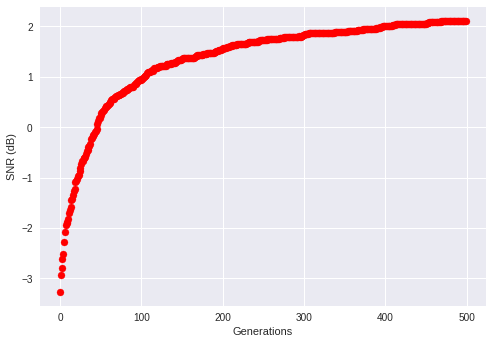

In [0]:
# Plotting SNR vs Generations
gen = np.arange(G)
plt.scatter(gen,gen_re,c='r')
plt.xlabel('Generations')
plt.ylabel('SNR (dB)')
#plt.rcParams['figure.figsize']=(2,1)

In [0]:
# Reading data file into COLAB environment
from google.colab import files

uploaded = files.upload()

Saving test8.wav to test8.wav


In [0]:
# Reconstructing signal using a member from the initial population.
test_sig, rate = sf.read('test8.wav')
sig_samp_one = np.dot(first_one,test_sig)
A1_one = np.dot(first_one,A)
r_sigf_one = np.dot(np.transpose(A1_one), sig_samp_one)
r_sigt_one = spfft.idct(r_sigf_one, norm='ortho', axis=0)
O_SNR = 10*math.log10(np.sum(r_sigt_one**2)/np.sum((r_sigt_one-test_sig)**2))
print(O_SNR)
Audio(data=r_sigt_one, rate=rate)

-6.8102993090521835


In [0]:
# Important stuff needed
cm = slcted[0,:,:]
sig_samp = np.dot(cm,test_sig)
A1 = np.dot(cm,A)

In [0]:
# Linear Reconstruction
%%time
r_sigf = np.dot(np.transpose(A1), sig_samp)
r_sigt = spfft.idct(r_sigf, norm='ortho', axis=0)

CPU times: user 7.6 ms, sys: 4.06 ms, total: 11.7 ms
Wall time: 13.5 ms


In [0]:

# Linear SNR and Sound
I_SNR = 10*math.log10(np.sum(r_sigt**2)/np.sum((r_sigt-test_sig)**2))
print(O_SNR)
Audio(data=r_sigt, rate=rate)

-6.8102993090521835


In [0]:
# Orthogonal Matching Pursuit
%%time
n_nonzero_coefs = m
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
omp.fit(A1, sig_samp)
coef = omp.coef_
omp_sigt = spfft.idct(coef, norm='ortho', axis=0)

CPU times: user 1.19 s, sys: 421 ms, total: 1.61 s
Wall time: 823 ms


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)


In [0]:
# OMP SNR and Sound
O_SNR = 10*math.log10(np.sum(omp_sigt**2)/np.sum((omp_sigt-test_sig)**2))
print(O_SNR)
Audio(data=omp_sigt, rate=rate)

16.27394298280534


In [0]:
# L1 optimization
%%time
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A1*vx == sig_samp]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
sig_bin = np.array(vx.value)
sig_bin = np.squeeze(sig_bin)
cvx_sigt = spfft.idct(sig_bin, norm='ortho', axis=0)

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 4162, constraints m = 4786
          nnz(P) + nnz(A) = 1115416
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1  -1.6648e+04   8.00e+00   4.06e+04   1.00e-01   1.47e+00s
 200   9.2828e+00   1.92e-02   3.29e-03   1.00e-01   2.99e+00s
 400   1.1390e+01   8.33e-03   1.08e-03   1.00e-01   4.57

In [0]:
# L1 SNR and Sound
CVX_SNR = 10*math.log10(np.sum(cvx_sigt**2)/np.sum((cvx_sigt-test_sig)**2))
print(CVX_SNR)
Audio(data=cvx_sigt, rate=rate)

18.390404115877402
